In [49]:
import os
import time
import logging
import argparse

In [50]:
import pytorch_lightning as pl
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [51]:
from dataloader import HairNetDataset
from model_rewrite import HairNetModelOriginal, MyLoss, CollisionLoss, CurMSE, PosMSE, HairNetLossRewrite
from src.train_new import HairNetLightning

In [52]:
log = logging.getLogger("HairNet")
logging.basicConfig(level=logging.INFO)

In [53]:
def get_args():
    parser = argparse.ArgumentParser()
    parser.add_argument("--epoch", type=int, default=100)
    parser.add_argument("--batch_size", type=int, default=32)  # 32
    parser.add_argument("--lr", type=float, default=0.0001)
    parser.add_argument("--lr_step", type=int, default=50)
    parser.add_argument("--save_dir", type=str, default="./weight/")
    parser.add_argument("--data", type=str, default="..")
    parser.add_argument("--weight", type=str, default="")
    parser.add_argument("--test_step", type=int, default=10)
    return parser.parse_known_args()

In [54]:
def train(model, dataloader, optimizer, device):
    model.train()
    my_loss = 1e10
    for i, data in enumerate(dataloader, 0):
        img, convdata, visweight = data

        img = img.to(device)
        convdata = convdata.to(device)
        visweight = visweight.to(device)
        # img (bs, 3, 128, 128); convdata (bs, 100, 4, 32, 32); visweight (bs, 100, 32, 32)

        optimizer.zero_grad()

        output = net(img)
        my_loss = loss(output, convdata, visweight)

        my_loss.backward()

        optimizer.step()

    return my_loss

In [55]:
def test(model, dataloader, device):
    pos_error = PosMSE().to(device)  # Position Loss
    cur_error = CurMSE().to(device)  # Curvature Loss
    col_error = CollisionLoss().to(device)  # Collision Loss

    # tot_error = MyLoss().to(device)

    model.eval()
    for i, data in enumerate(dataloader, 0):
        img, convdata, visweight = data

        img = img.to(device)
        convdata = convdata.to(device)
        visweight = visweight.to(device)

        output = model(img)

        # cal loss
        pos = pos_error(output, convdata, visweight)
        cur = cur_error(output, convdata, visweight)
        col = col_error(output, convdata)

        tot = pos + cur + col

        log.info(
            f"TESTING Epoch {i+1} | Loss[ Pos | Cur | Col | Total ]: "
            f"[ {pos:.8f} | {cur:.8f} | {col:.8f} | {tot:.8f} ]"
        )

    # return pos.item(), cur.item(), col.item(), tot.item()

INFO:HairNet:Training args: Namespace(epoch=100, batch_size=32, lr=0.0001, lr_step=50, save_dir='./weight/', data='..', weight='', test_step=1)
INFO:HairNet:Training device: cuda
INFO:HairNet:Initializing model and loss function ...
INFO:HairNet:Loading data ...
INFO:HairNet:Train dataset: 4000 data points
INFO:HairNet:Test dataset: 26440 data points
INFO:HairNet:Training ...


RuntimeError: Sizes of tensors must match except in dimension 2. Expected size 3 but got size 1 for tensor number 1 in the list.

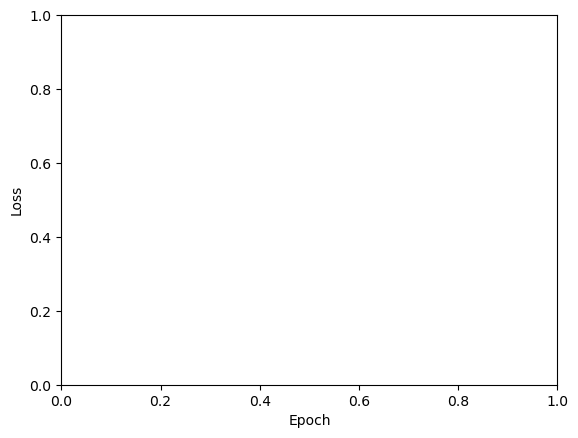

In [56]:
if __name__ == "__main__":
    # load parameters
    opt, unknown = get_args()
    epochs, bs, lr, lr_step, save_dir, data, weight, test_step = (
        opt.epoch,
        opt.batch_size,
        opt.lr,
        opt.lr_step,
        opt.save_dir,
        opt.data,
        opt.weight,
        opt.test_step,
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    log.info(f"Training args: {opt}")
    log.info(f"Training device: {device}")

    log.info("Initializing model and loss function ...")

    net = HairNetLightning(opt)
    

    #
    # net = HairNetModelOriginal().to(device)
    # loss = HairNetLossRewrite().to(device)

    if weight != "":
        log.info("Loading model's weight ...")
        net.load_state_dict(torch.load(weight, map_location=torch.device(device)))

    # load data
    log.info("Loading data ...")
    train_data = HairNetDataset(project_dir=data, train_flag=1, noise_flag=1)
    train_loader = DataLoader(dataset=train_data, batch_size=bs)
    log.info(f"Train dataset: {len(train_data)} data points")

    if test_step != 0:
        test_data = HairNetDataset(project_dir=data, train_flag=0, noise_flag=0)
        test_loader = DataLoader(dataset=test_data, batch_size=bs)
        log.info(f"Test dataset: {len(test_data)} data points")

    # setup optimizer & lr schedualer
    optimizer = optim.Adam(net.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    t = time.localtime()
    save_path = save_dir + time.strftime("%Y_%m_%d_%H_%M_%S", t)
    os.mkdir(save_path)

    # train
    log.info("Training ...")
    pre_loss = 100000

    losses = []
    fig, ax = plt.subplots()
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')

    for epoch in range(epochs): 
        # measure executive time
        # torch.cuda.synchronize()
        since = int(round(time.time() * 1000))

        train_loss = train(net, train_loader, optimizer, device)
        losses.append(train_loss.cpu().detach())

        ax.plot(losses)
        fig.canvas.draw()

        scheduler.step()

        # torch.cuda.synchronize()
        time_elapsed = int(round(time.time() * 1000)) - since

        # Logging
        log.info(
            f"TRAINING Epoch {epoch+1} | Loss: {train_loss:.8f} | time: {time_elapsed}ms"
        )
        if test_step != 0 and (epoch + 1) % test_step == 0:
            test(net, test_loader, device)

        # Save model by performance
        if train_loss < pre_loss:
            pre_loss = train_loss
            torch.save(net.state_dict(), save_path + "/weight.pt")